In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy.interpolate import interp1d
import importlib

from source import plots
from source import prob_dists as pd


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
n = 0
params = {'R_G': 220, # Kpc
          'd_solar': 8.5, # kpc
          'psi': 80,
          'M_min': 1.0e-2, # Msun
          'M_max': 1.0e10, # Msun
          'fwimp': 1.0,
          'mean_params': {'a':77.4, 'b':0.87+0.31*n, 'c':-0.23-0.04*n},
          'nside': 2048,
          'area_fermi': 2000.0, # cm^2
          'n': n,
          'log_flux_min': -15, # log10 photons/cm^2/yr
          'log_flux_max': -7, # log10 photons/cm^2/yr
          'N': 10000,
          'log_k_min': 3,
          'log_k_max': 9,
          'N_k': 10000,
          'psh_log_f_min': -8,
          'psh_log_f_max': -6,
          'N_psh': 500
         }

params['omega_pixel'] = 4.*np.pi/(12*params['nside']**2.) # sr
p = params

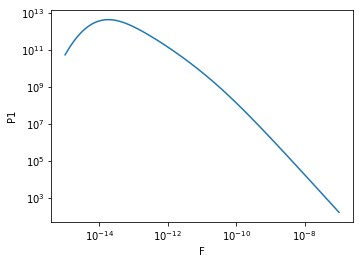

In [3]:
fluxes = np.logspace(p['log_flux_min'], p['log_flux_max'], num=p['N'])
p1_vals = pd.p1(fluxes, **p)
fig, _ = plots.check_p1_plot(fluxes, p1_vals)

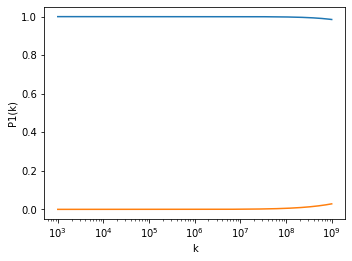

In [4]:
muu = pd.mu(**p)
ft_p1_vals, k = pd.ft_p1(p1_vals, fluxes, **p)
fig, _ = plots.check_ft_p1_plot(k, ft_p1_vals)

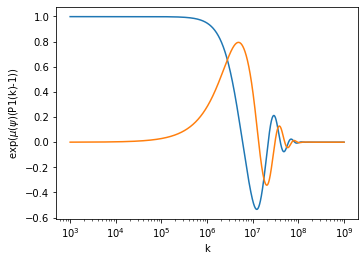

In [5]:
fig, _ = plots.check_psh_integrand_plot(k, ft_p1_vals, muu)



In [6]:
pf_vals, flux = pd.pf(muu, ft_p1_vals, k, **p)

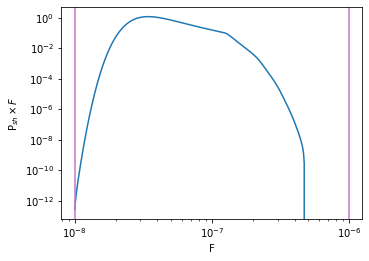

In [13]:
startl = 0
limi = -1
fig, _ = plots.check_psh_plot(flux, pf_vals.real, j=[startl, limi])

# print(pf_vals)

In [14]:
print(f'\mu \int F P1: {(muu * integrate.simps(fluxes * p1_vals, fluxes))}')
print(f' \int F Psh: {integrate.simps(pf_vals[startl:limi].real * flux[startl:limi], flux[startl:limi])}')



\mu \int F P1: [4.63011476e-08]
 \int F Psh: 4.622081064771558e-08


Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 4.630116927688521e-08
 \int F Psh: 4.622144242502742e-08
percent error = -0.17%



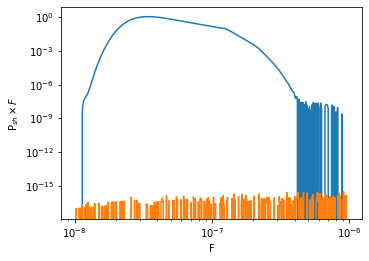

In [9]:
pshvals, fxs = pd.psh(params, plot=True, infer_values=True)

 \int F Psh: 4.6220781905101027e-08


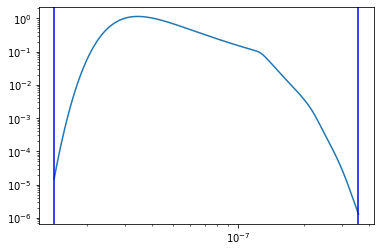

In [10]:
plt.plot(fxs, fxs * pshvals.real)
ax = plt.gca()
startl = 0
limi = -1
ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(fxs[startl], color='b')
ax.axvline(fxs[limi], color='b')

print(f' \int F Psh: {integrate.simps(pshvals[startl:limi].real * fxs[startl:limi], fxs[startl:limi])}')



Angle: 40.0
Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 9.922695415554573e-08
 \int F Psh: 9.89964534857742e-08
percent error = -0.23%

Angle: 52.5
Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 7.467021623214654e-08
 \int F Psh: 7.451319819933172e-08
percent error = -0.21%

Angle: 65.0
Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 5.881802098863501e-08
 \int F Psh: 5.8705468681849656e-08
percent error = -0.19%

Angle: 77.5
Got P1(F) values
inferred log_k_max 8.500000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 4.8032675493536124e-08
 \int F Psh: 4.794855136674891e-08
percent error = -0.18%

Angle: 90.0
Got P1(F) values
inferred log_k_max 9.000000000000018
Finished FT of P1
Finished Psh computation
\mu \int F P1: 4.044169009246113e-08
 \int F Psh: 4.037643404934788e-0

[Text(1, 0, '40.0'),
 Text(1, 0, '50.0'),
 Text(1, 0, '60.0'),
 Text(1, 0, '70.0'),
 Text(1, 0, '80.0'),
 Text(1, 0, '90.0')]

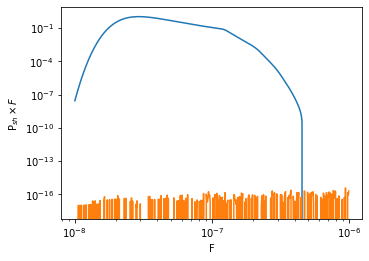

In [11]:
numnum = 5
psis = np.linspace(40, 90, num=numnum)
colors = cm.viridis(np.linspace(0, 1, num=numnum))

fig, ax = plt.subplots()

psh_vals_over_psi = []

for psi, col in zip(psis, colors):
    p['psi'] = psi
    print('Angle:', psi)
    pshvals, fxs = pd.psh(params, plot=True, infer_values=True)
    
    psh_vals_over_psi.append((pshvals, fxs))
    
    ax.plot(fxs, fxs * pshvals.real, label=rf"{psi}$^\circ$", color=col)
   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('F')
ax.set_ylabel('F x Psh')
cbarlabs = np.arange(min(psis), max(psis)+1, step=10)
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ticks=np.linspace(0, 1, num=len(cbarlabs)))
cbar.set_label(r'$\psi$[$^\circ$]', rotation=270)
cbar.ax.set_yticklabels(cbarlabs)

In [12]:
fig.savefig('./output/psh_n0.png')
fig

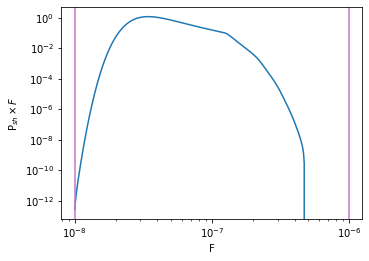